In [11]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

The purpose of this code is to encode and decode morse code using neurons based on user input of ASCII character(s).

In [12]:
# Dictionary for transition to and from neurons. Used in encoding and decoding process.
Morse = {
    # codes from https://www.itu.int/rec/R-REC-M.1677-1-200910-I/en
    "A": "10111",  # 0
    "B": "111010101",  # 1
    "C": "11101011101",  # 2
    "D": "1110101",  # 3
    "E": "1",  # 4
    "F": "101011101",  # 5
    "G": "111011101",  # 6
    "H": "1010101",  # 7
    "I": "101",  # 8
    "J": "1011101110111",  # 9
    "K": "111010111",  # 10
    "L": "101110101",  # 11
    "M": "1110111",  # 12
    "N": "11101",  # 13
    "O": "11101110111",  # 14
    "P": "10111011101",  # 15
    "Q": "1110111010111",  # 16
    "R": "1011101",  # 17
    "S": "10101",  # 18
    "T": "111",  # 19
    "U": "1010111",  # 20
    "V": "101010111",  # 21
    "W": "101110111",  # 22
    "X": "11101010111",  # 23
    "Y": "1110101110111",  # 24
    "Z": "11101110101",  # 25
    " ": "0",  # 26
    "1": "10111011101110111",  # 27
    "2": "101011101110111",  # 28
    "3": "1010101110111",  # 29
    "4": "10101010111",  # 30
    "5": "101010101",  # 31
    "6": "11101010101",  # 32
    "7": "1110111010101",  # 33
    "8": "111011101110101",  # 34
    "9": "11101110111011101",  # 35
    "0": "1110111011101110111",  # 36
    ".": "10111010111010111",  # 37
    ",": "1110111010101110111",  # 38
    ":": "11101110111010101",  # 39
    "?": "101011101110101",  # 40
    "'": "1011101110111011101",  # 41
    "-": "111010101010111",  # 42
    "/": "1110101011101",  # 43
    "(": "111010111011101",  # 44
    ")": "1110101110111010111",  # 45
    '"': "101110101011101",  # 46
    "=": "1110101010111",  # 47
    "+": "1011101011101",  # 48
    "@": "10111011101011101",  # 49
    # these punctuation marks are not included in the ITU recommendation,
    # but are found in https://en.wikipedia.org/wiki/Morse_code
    "!": "1110101110101110111",  # 50
    "&": "10111010101",  # 51
    ";": "11101011101011101",  # 52
    "_": "10101110111010111",  # 53
    "$": "10101011101010111",  # 54
}
keys = list(Morse.keys())

Ask for user input here and return an array with the input in morse code.

In [13]:
# take user input
msg = input("Type phrase to translate here: ")
print("\n", msg)
# convert to all uppercase
msg = msg.upper()
# transform from string to an array with each character a separate element
msg = list(msg)
print("\n", msg)
my_morse = []
# evaluate each character in the list and convert to morse
for i in msg:
    my_morse.append(Morse.get(i))

print("\n", my_morse, "\n")
print(len(my_morse))


 Z

 ['Z']

 ['11101110101'] 

1


Use this code to turn the input from an array with one string in it to an array with as many elements as the length of the string.

In [14]:
# parse the list into individual 1's and 0's.
temp_inputs = [
    int for string in my_morse for int in string
]  # got this line from Chat GPT
# add four 0's to the end of each character
for i in range(0, 4):
    temp_inputs.append("0")
print(temp_inputs)

['1', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '0']


The brain of the project. Includes functions for inputting piecewise functions and for connecting the neurons. 

In [15]:
model = nengo.Network(label="Mercier Final Project")

send_inp = []  # 1 for dot; 2 for dash
count = 0
# determine if there is a dot or dash
for i in range(len(temp_inputs)):
    # current is a 1 and there is three 1's in a row - append a 2 (dash)
    if temp_inputs[i] == "1":
        count += 1
        if count == 3:
            send_inp.append(2)
            count = 0
    # current is a 0 and the count of 1's is 1 - append a 1 (dot)
    if temp_inputs[i] == "0" and count == 1:
        send_inp.append(1)
        count = 0
    # need to add condidtion for stringing two characters together
print(send_inp)

with model:
    # function for input node (takes array with 1,2 format)
    def input_func(array_in):
        t = [0]
        x = [0]
        for i in array_in:
            # if there is a dot, first send 0 for .33 s then a pulse (h=.5) for .33 s.
            if i == 1:
                x.append(0.5)
                x.append(0)
                t.append(t[-1] + 0.33)
                t.append(t[-1] + 0.33)
            # if there is a dash, first send 0 for .33 s then a pulse for 1 s.
            elif i == 2:
                x.append(1)
                x.append(0)
                t.append(t[-1] + 0.33)
                t.append(t[-1] + 1)
        piecewise = Piecewise({time: value for time, value in zip(t, x)})
        return piecewise

    # determine if the inputs are close - if close output 1, if far output 0
    def check(x):
        if np.abs(x[0] - x[1]) < 0.15:
            return 1
        else:
            return 0

    input_node = nengo.Node(input_func(send_inp))

    check_list = []
    for i in Morse:
        val = Morse[i]
        # parse the list into individual 1's and 0's.
        val = [int for string in val for int in string]  # got this line from Chat GPT
        # add four 0's to the end of each character
        for i in range(0, 4):
            val.append("0")
        # determine if there is a dot or dash
        for i in range(len(val)):
            # current is a 1 and there is three 1's in a row - append a 2 (dash)
            if val[i] == "1":
                count += 1
                if count == 3:
                    val.append(2)
                    count = 0
            # current is a 0 and the count of 1's is 1 - append a 1 (dot)
            if val[i] == "0" and count == 1:
                val.append(1)
                count = 0
        check_list.append(nengo.Node(input_func(val)))

[2, 2, 1, 1]


Create the model and make connections and probes.

In [16]:
with model:
    # Create ensemble. Increase n_neurons for more accurate results.
    ensembleA = nengo.Ensemble(n_neurons=200, dimensions=1)
    nengo.Connection(input_node, ensembleA)
    # check, cobmine, out ensemble list.
    check_ensemble_list = []
    combine_ensemble_list = []
    out_ensemble_list = []
    for i in range(len(check_list)):
        check_ensemble_list.append(
            nengo.Ensemble(n_neurons=200, dimensions=1)
        )  # dictionary values
        combine_ensemble_list.append(
            nengo.Ensemble(n_neurons=200, dimensions=2, radius=1.5)
        )  # combine dictionary and input value, radius 1.5 because 2D
        out_ensemble_list.append(
            nengo.Ensemble(n_neurons=200, dimensions=1)
        )  # output of combined
        nengo.Connection(check_list[i], check_ensemble_list[i])
        nengo.Connection(check_ensemble_list[i], combine_ensemble_list[i][0])
        nengo.Connection(ensembleA, combine_ensemble_list[i][1])
        nengo.Connection(combine_ensemble_list[i], out_ensemble_list[i], function=check)
    # Probe the node
    probe1 = nengo.Probe(input_node)
    # Probe the ensemble
    probe2 = nengo.Probe(ensembleA, synapse=0.01)

    probe3 = []
    probe4 = []
    for i in range(len(check_ensemble_list)):
        # probe output
        probe3.append(nengo.Probe(out_ensemble_list[i], synapse=0.01))
        # probe dic value
        probe4.append(nengo.Probe(check_ensemble_list[i], synapse=0.01))

Run the simulation.

In [17]:
# length to run simulation (must be long enough to represent each character)
sim_time = 7
with nengo.Simulator(model) as sim:
    # run for sim_time seconds
    sim.run(sim_time)

Build finished in 0:00:08.                                                      
Simulation finished in 0:00:29.                                                 


Plot the probes.

Text(0.5, 1.0, 'Neuron Input')

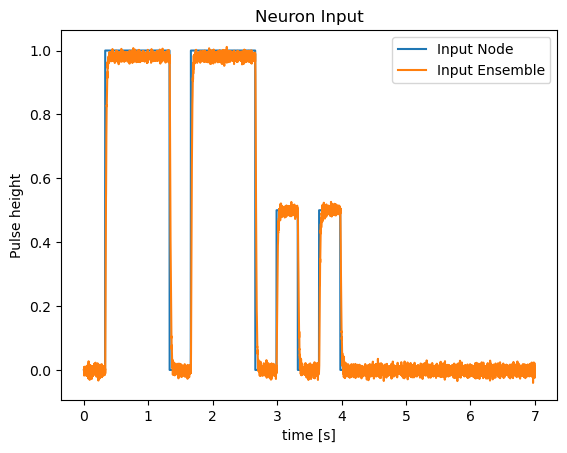

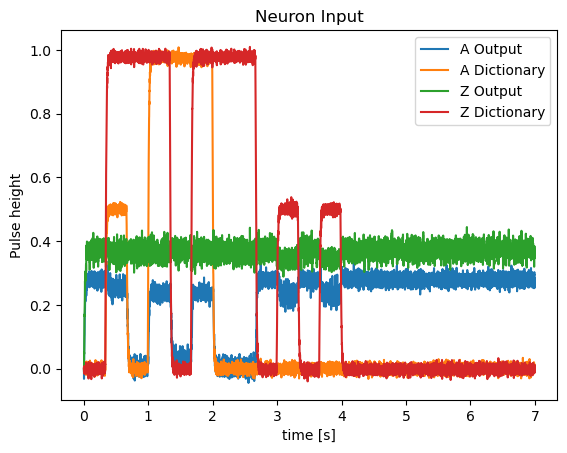

In [18]:
# input node and ensemble
plt.figure()
plt.plot(sim.trange(), sim.data[probe1], label="Input Node")
plt.plot(sim.trange(), sim.data[probe2], label="Input Ensemble")
plt.legend(loc="upper right")
plt.xlabel("time [s]")
plt.ylabel("Pulse height")
plt.title("Neuron Input")

# Probe3 - Outputs, Probe4 - Dictionary values
plt.figure()
# for i in range(len(probe4)):
# plt.plot(sim.trange(), sim.data[probe3[i]], label=i)
# plt.plot(sim.trange(), sim.data[probe4[i]], label=i)
plt.plot(sim.trange(), sim.data[probe3[0]], label="A Output")
plt.plot(sim.trange(), sim.data[probe4[0]], label="A Dictionary")
plt.plot(sim.trange(), sim.data[probe3[25]], label="Z Output")
plt.plot(sim.trange(), sim.data[probe4[25]], label="Z Dictionary")
plt.legend(loc="upper right")
plt.xlabel("time [s]")
plt.ylabel("Pulse height")
plt.title("Neuron Input")

Below this is off-neuron processing of the data to determine inputted value.

In [19]:
dt = 0.001
count = []
# determine input from combined output
for i in range(len(probe3)):
    # look at spikes greater than .2
    aer = sim.data[probe3[i]][:, 0] > 0.2
    # turn into array of spike values
    spiking = np.asarray(np.where(aer == True))
    # account for python syntax by filling 0 for empty array
    if spiking.size == 0:
        count.append(0)
    # count array holds how many spike values above .2 for each output
    else:
        count.append(len(spiking[0]))
# the ans (input) is the count index which holds the maximum count value (most spikes above .2 occurs where the two neuron ensembles are most similar)
ans = count.index(np.max(count))
# print answer
print("The inputted key is: ", keys[ans])

The inputted key is:  Z
